## Descrição do problema

<p align="center">
    <img alt="H&M Logo" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/H%26M-Logo.svg/1920px-H%26M-Logo.svg.png" width="200">
</p>

Para este desafio é disponibilizado o histórico de compras dos clientes ao longo do tempo da empresa H&M Group, juntamente com metadados de surporte.
O desafio consiste em prever quais artigos cada cliente comprará no período de 7 dias imediatamente após o términio dos dados de treinamento.
O cliente que não fez nenhuma compra durante esse período é excluído da pontuação.

O conjunto de dados contém 4 arquivos  csv (articles.cvs, customers.cvs, transactions_train.cvs, sample_submission.cvs) e uma pasta com várias subpastas, cada uma com um número diferente de imagens.

O desafio deixa em aberto como será feita a analise e utilizaçãop dos dados para atingir o objetivo.


## Aplicação

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
sns.set_theme(style="ticks", palette="pastel")

In [2]:
transactions = pd.read_csv('data/transactions_train.csv')

In [232]:
articles = pd.read_csv('data/articles.csv')

In [4]:
customers = pd.read_csv('data/customers.csv')

### Analise dos dados

#### Utils

In [5]:
#IQR (Intervalo Interquartil)
def interval_interquartil(dt, col):
  Q1=dt[col].quantile(0.25)
  Q3=dt[col].quantile(0.75)
  IQR=Q3-Q1
  whisker_width = 1.5
  return dt[(dt[col] < Q1 - whisker_width*IQR) | (dt[col] > Q3 + whisker_width*IQR)]
  
def not_interval_interquartil(dt, col):
  Q1=dt[col].quantile(0.25)
  Q3=dt[col].quantile(0.75)
  IQR=Q3-Q1
  whisker_width = 1.5
  return dt[(dt[col] > Q1 - whisker_width*IQR) & (dt[col] < Q3 + whisker_width*IQR)]

def graph(dt, col):
    plt.figure(figsize=[16,4])
    plt.suptitle('[' + col + ']')

    plt.subplot(1, 2, 1)
    dt[col].value_counts().plot(kind='bar')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=col, data=dt)

def graph__plot(dt, col):
    dt[col].value_counts().plot(kind='bar')

In [6]:
def normalize(dt, attribute):
  dt[attribute] = (dt[attribute] - dt[attribute].min()) / (dt[attribute].max() - dt[attribute].min())

#### Transactions

In [7]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [8]:
transactions.shape

(31788324, 5)

In [9]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

t_dat: data da transação `Date` (categórico nominal)

customer_id: id do cliente que fez a transação `String` (categórico nominal)

article_id: id do produto (artigo) comprado na transação `int64` (quantitativo discretos)

price: preço do produto comprado `float64` (quantitativo contínuo)

sales_channel_id: canal de vendas utilizado na transação (1 (loja) ou 2 (online)) `Int64` (quantitativo discreto e binário simétrico)

In [10]:
transactions['sales_channel_id'] = transactions['sales_channel_id'].astype(np.int8)
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id       int8
dtype: object

In [11]:
transactions.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [12]:
pd.get_dummies(transactions["sales_channel_id"]).head()

,1,2
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


<AxesSubplot:xlabel='price'>

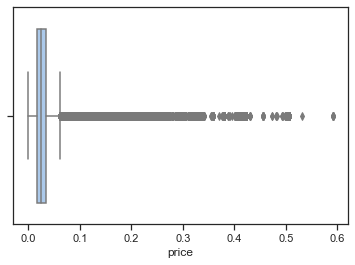

In [13]:
sns.boxplot(x='price', data=transactions)

In [14]:
max_price = transactions['price'].max()
print(f"Max price: {max_price}")

Max price: 0.5915254237288136


In [15]:
display(transactions['customer_id'].value_counts()[:20])

be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
55d15396193dfd45836af3a6269a079efea339e875eff42cc0c228b002548a9d    1208
c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27cf9bda5517c8774f8fa    1170
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076    1169
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296    1157
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55    1143
e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffccd515dd5cef56126efb    1117
3493c55a7fe252c84a9a03db338f5be7afbce1edbca12f3a908fac9b983692f2    1115
0bf4c6fd4e9d33f9bfb807bb78348cbf5c565846ff4006acf5c1b9aea77b0e54    1099
e6498c7514c61d3c24669f49753dc83fdff3ec1ba13902dd918

<AxesSubplot:>

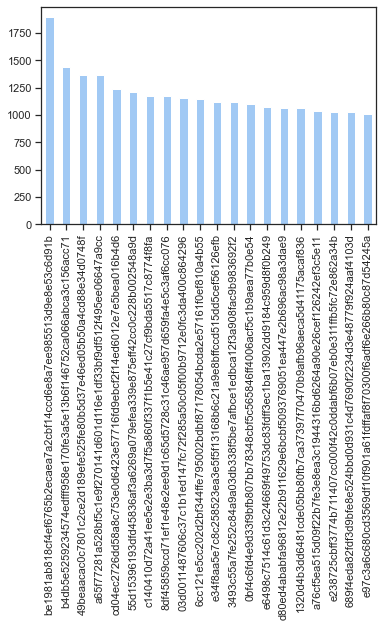

In [17]:
transactions['customer_id'].value_counts()[:20].plot(kind='bar')

In [18]:
transactions_counts = transactions['customer_id'].value_counts().rename_axis('customer_id').reset_index(name='counts')
transactions_counts

,customer_id,counts
0,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,1895
1,b4db5e5259234574edfff958e170fe3a5e13b6f146752c...,1441
2,49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05...,1364
3,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,1361
4,cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed...,1237
...,...,...
1362276,63b70b71291668f0a63ade8e321fb3eccb80eba164f208...,1
1362277,950b172c36d169bf427545991fe66371f21a085799b447...,1
1362278,7c284f13f4af9d6a53f97279381638ed0cb7afaa4fd4f3...,1
1362279,62d49d0ae11a4f65fa31e354cb87f6b557ebec648e0e5e...,1


In [19]:
pd.set_option('float_format', '{:f}'.format)
transactions_counts.describe()

,counts
count,1362281.000000
mean,23.334631
std,39.242253
min,1.000000
25%,3.000000
50%,9.000000
75%,27.000000
max,1895.000000


In [20]:
display(transactions['article_id'].value_counts()[:20])

706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
464297007    25025
372860002    24458
610776001    22451
399223001    22236
706016003    21241
720125001    21063
156231001    21013
562245046    20719
562245001    20464
351484002    20415
399256001    20242
673396002    19834
568601006    19379
448509014    19216
673677002    19143
Name: article_id, dtype: int64

<AxesSubplot:>

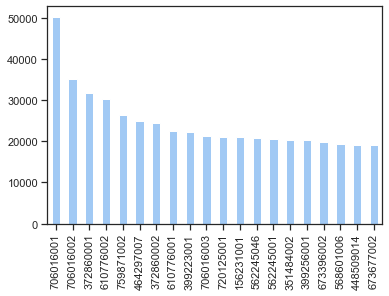

In [21]:
transactions['article_id'].value_counts()[:20].plot(kind='bar')

In [22]:
transactions.loc[transactions['article_id'] == 706016001]['price'].value_counts()

0.033881    34760
0.027102     3510
0.030492     3136
0.028797      928
0.024390      500
            ...  
0.028068        1
0.023373        1
0.028390        1
0.028119        1
0.024119        1
Name: price, Length: 563, dtype: int64

In [23]:
transactions['article_id'].value_counts().rename_axis('article_id').reset_index(name='counts')

,article_id,counts
0,706016001,50287
1,706016002,35043
2,372860001,31718
3,610776002,30199
4,759871002,26329
...,...,...
104542,520736002,1
104543,619777003,1
104544,586904003,1
104545,512385003,1


In [24]:
print('The number of customers: ', transactions['customer_id'].nunique())
print('The number of articles: ', transactions['article_id'].nunique())

The number of customers:  1362281
The number of articles:  104547


In [25]:
max_x = transactions['t_dat'].max()
min_x = transactions['t_dat'].min()
print(f"Início: {min_x}\nFim: {max_x}")

Início: 2018-09-20
Fim: 2020-09-22


Dados de transações em um intervalo de 2 anos e 2 dias

In [26]:
mask = transactions['t_dat'] > '2019-09-22'
transactions_last_year = transactions.loc[mask]

In [27]:
print('The number of customers: ', transactions_last_year['customer_id'].nunique())
print('The number of articles: ', transactions_last_year['article_id'].nunique())

The number of customers:  994320
The number of articles:  70906


In [28]:
transactions.describe()

,article_id,price,sales_channel_id
count,31788324.000000,31788324.000000,31788324.000000
mean,696227219.133793,0.027829,1.704028
std,133448003.487313,0.019181,0.456479
min,108775015.000000,0.000017,1.000000
25%,632803008.000000,0.015814,1.000000
50%,714582003.000000,0.025407,2.000000
75%,786524001.000000,0.033881,2.000000
max,956217002.000000,0.591525,2.000000


#### Articles

In [233]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [234]:
articles.shape

(105542, 25)

article_id : Identificador unico de cada artigo

product_code, prod_name : Identificador unico para cada produto e seu nome

product_type, product_type_name : Grupo no qual o produto pertece pelo código e seu nome

graphical_appearance_no, graphical_appearance_name : Grupo de "aparência gráfica" e seu nome

colour_group_code, colour_group_name : Grupo de cores e seu nome

perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name : Informações de cores adicionais

department_no, department_name: : Identificador unico de cada departamento e seu nome

index_code, index_name: : ??

index_group_no, index_group_name: : ??

section_no, section_name: : Identificador unico de cada seção e seu nome

garment_group_no, garment_group_name: : Identificador unico de cada peça de roupa e seu nome

detail_desc: : Detalhes

In [235]:
articles.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [236]:
#preenchendo valor null em detail_desc
articles['detail_desc'].fillna("empty description", inplace=True)

In [237]:
articles.isnull().sum()

article_id                      0
product_code                    0
prod_name                       0
product_type_no                 0
product_type_name               0
product_group_name              0
graphical_appearance_no         0
graphical_appearance_name       0
colour_group_code               0
colour_group_name               0
perceived_colour_value_id       0
perceived_colour_value_name     0
perceived_colour_master_id      0
perceived_colour_master_name    0
department_no                   0
department_name                 0
index_code                      0
index_name                      0
index_group_no                  0
index_group_name                0
section_no                      0
section_name                    0
garment_group_no                0
garment_group_name              0
detail_desc                     0
dtype: int64

In [238]:
for col in ["product_code", "product_type_no", "graphical_appearance_no",
            "department_no", "index_code", "index_group_no",
            "section_no", "garment_group_no", "detail_desc"]:
    print(f"{col}\t>> {articles[col].nunique()} number of unique categories.")

product_code	>> 47224 number of unique categories.
product_type_no	>> 132 number of unique categories.
graphical_appearance_no	>> 30 number of unique categories.
department_no	>> 299 number of unique categories.
index_code	>> 10 number of unique categories.
index_group_no	>> 5 number of unique categories.
section_no	>> 57 number of unique categories.
garment_group_no	>> 21 number of unique categories.
detail_desc	>> 43405 number of unique categories.


In [239]:
cols = ['article_id', 'prod_name', 'product_group_name', 'product_type_name', 'graphical_appearance_name',
        'colour_group_name','perceived_colour_value_name','perceived_colour_master_name',
        'department_name','index_name','index_group_name','section_name','garment_group_name', 'detail_desc']
articles_nominal = articles[cols].copy()

In [240]:
articles_nominal.head()

,article_id,prod_name,product_group_name,product_type_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,108775015,Strap top,Garment Upper body,Vest top,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,Strap top,Garment Upper body,Vest top,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,Strap top (1),Garment Upper body,Vest top,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,OP T-shirt (Idro),Underwear,Bra,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,OP T-shirt (Idro),Underwear,Bra,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [241]:
cols_drop = ['prod_name', 'product_group_name', 'product_type_name', 'graphical_appearance_name',
        'colour_group_name','perceived_colour_value_name','perceived_colour_master_name',
        'department_name','index_name','index_group_name','section_name','garment_group_name',
        'index_group_name', 'detail_desc']
articles.drop(cols_drop, axis=1, inplace=True)

In [242]:
articles.dtypes

article_id                     int64
product_code                   int64
product_type_no                int64
graphical_appearance_no        int64
colour_group_code              int64
perceived_colour_value_id      int64
perceived_colour_master_id     int64
department_no                  int64
index_code                    object
index_group_no                 int64
section_no                     int64
garment_group_no               int64
dtype: object

In [243]:
articles

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,108775015,108775,253,1010016,9,4,5,1676,A,1,16,1002
1,108775044,108775,253,1010016,10,3,9,1676,A,1,16,1002
2,108775051,108775,253,1010017,11,1,9,1676,A,1,16,1002
3,110065001,110065,306,1010016,9,4,5,1339,B,1,61,1017
4,110065002,110065,306,1010016,10,3,9,1339,B,1,61,1017
...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,302,1010014,9,4,5,7188,F,3,26,1021
105538,953763001,953763,253,1010016,9,4,5,1919,A,1,2,1005
105539,956217002,956217,265,1010016,9,4,5,1641,A,1,18,1005
105540,957375001,957375,72,1010016,9,4,5,3946,D,2,52,1019


In [142]:
def iqr_fence(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - (1.5 * IQR)
    Upper_Fence = Q3 + (1.5 * IQR)
    u = max(x[x<Upper_Fence])
    l = min(x[x>Lower_Fence])
    return [u,l]

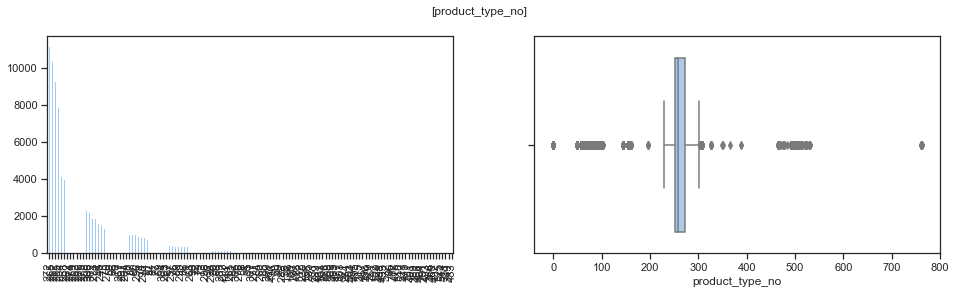

In [39]:
graph(articles, 'product_type_no')

In [40]:
interval_interquartil(articles, 'product_type_no')['product_type_no'].value_counts()

308    2356
306    2212
94     1621
75     1349
59     1307
       ... 
525       1
514       1
351       1
349       1
483       1
Name: product_type_no, Length: 89, dtype: int64

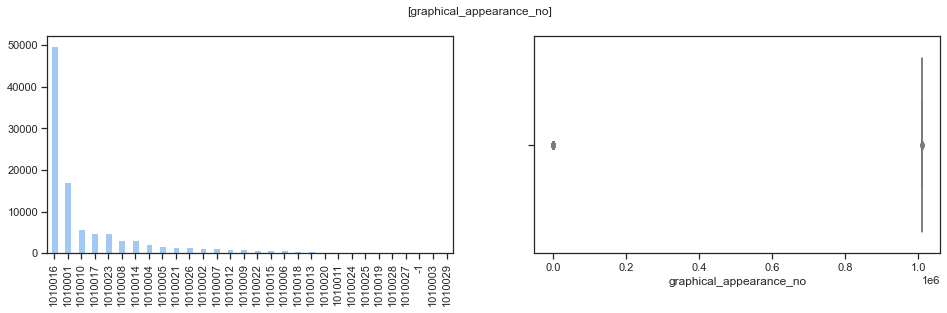

In [41]:
graph(articles, 'graphical_appearance_no')

In [42]:
interval_interquartil(articles, 'graphical_appearance_no')['graphical_appearance_no'].value_counts()

-1          52
 1010029     8
Name: graphical_appearance_no, dtype: int64

In [43]:
max_x = articles['graphical_appearance_no'].max()
min_x = articles['graphical_appearance_no'].min()
print(f"Min: {min_x}  Max: {max_x}")

Min: -1  Max: 1010029


In [44]:
max_x = articles.loc[articles['graphical_appearance_no'] != 1010029]['graphical_appearance_no'].max()
min_x = articles.loc[articles['graphical_appearance_no'] != -1]['graphical_appearance_no'].min()
print(f"Min: {min_x}  Max: {max_x}")

Min: 1010001  Max: 1010028


In [45]:
articles.loc[articles['graphical_appearance_no'] == -1, ['graphical_appearance_no']] = 1010000

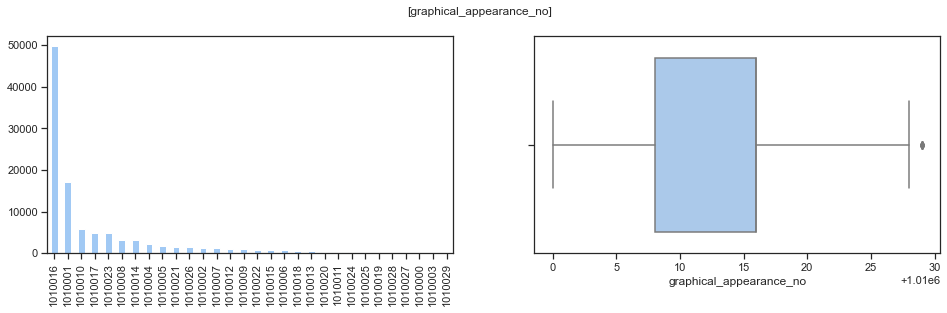

In [46]:
graph(articles, 'graphical_appearance_no')

In [47]:
interval_interquartil(articles, 'graphical_appearance_no')['graphical_appearance_no'].value_counts()

1010029    8
Name: graphical_appearance_no, dtype: int64

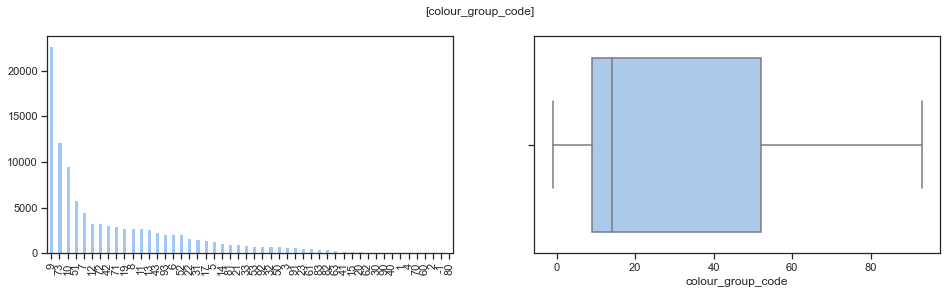

In [48]:
graph(articles, 'colour_group_code')

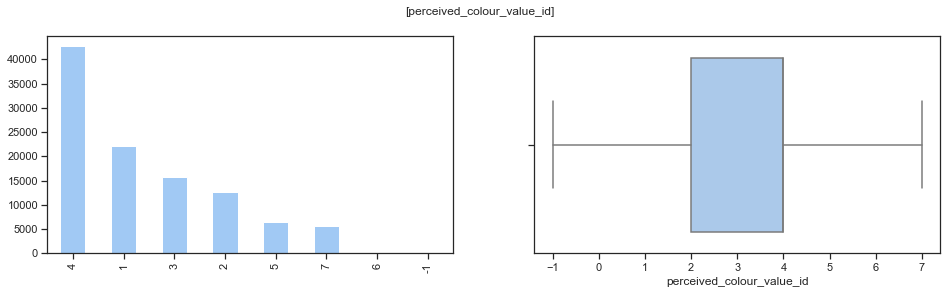

In [49]:
graph(articles, 'perceived_colour_value_id')

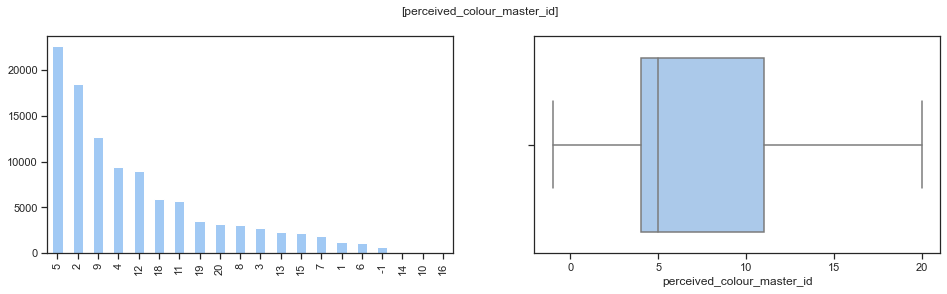

In [50]:
graph(articles, 'perceived_colour_master_id')

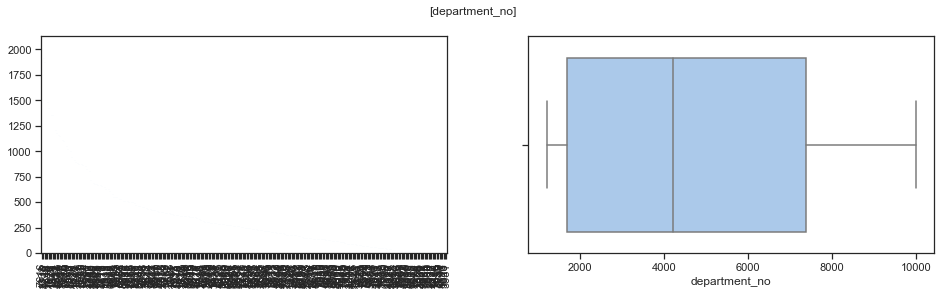

In [51]:
graph(articles, 'department_no')

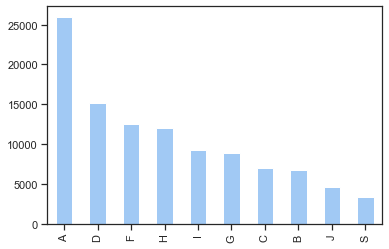

In [52]:
graph__plot(articles, 'index_code')

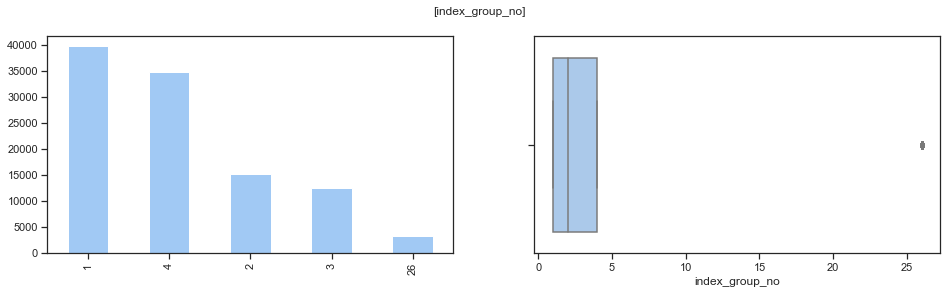

In [53]:
graph(articles, 'index_group_no')

In [54]:
print(articles['index_group_no'].value_counts())

1     39737
4     34711
2     15149
3     12553
26     3392
Name: index_group_no, dtype: int64


In [55]:
articles.loc[articles['index_group_no'] == 26, ['index_group_no']] = 5

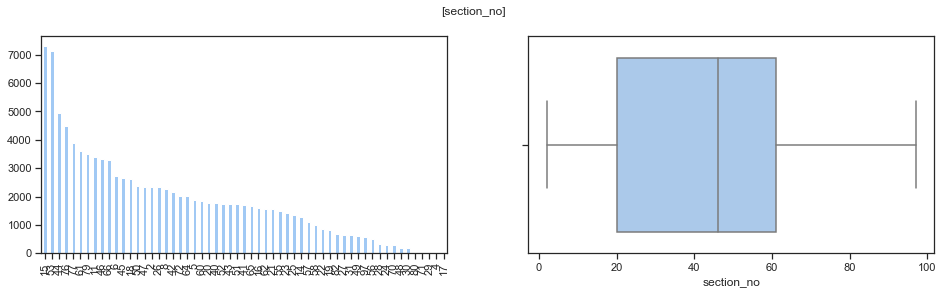

In [56]:
graph(articles, 'section_no')

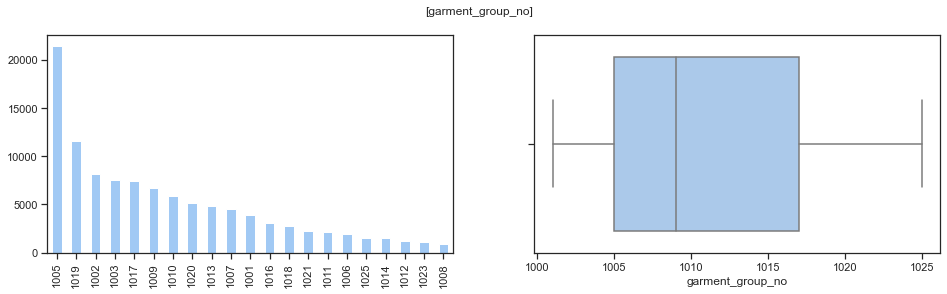

In [57]:
graph(articles, 'garment_group_no')

In [59]:
print(articles['product_code'].value_counts())

783707    75
684021    70
699923    52
699755    49
685604    46
          ..
761368     1
761366     1
761360     1
761350     1
959461     1
Name: product_code, Length: 47224, dtype: int64


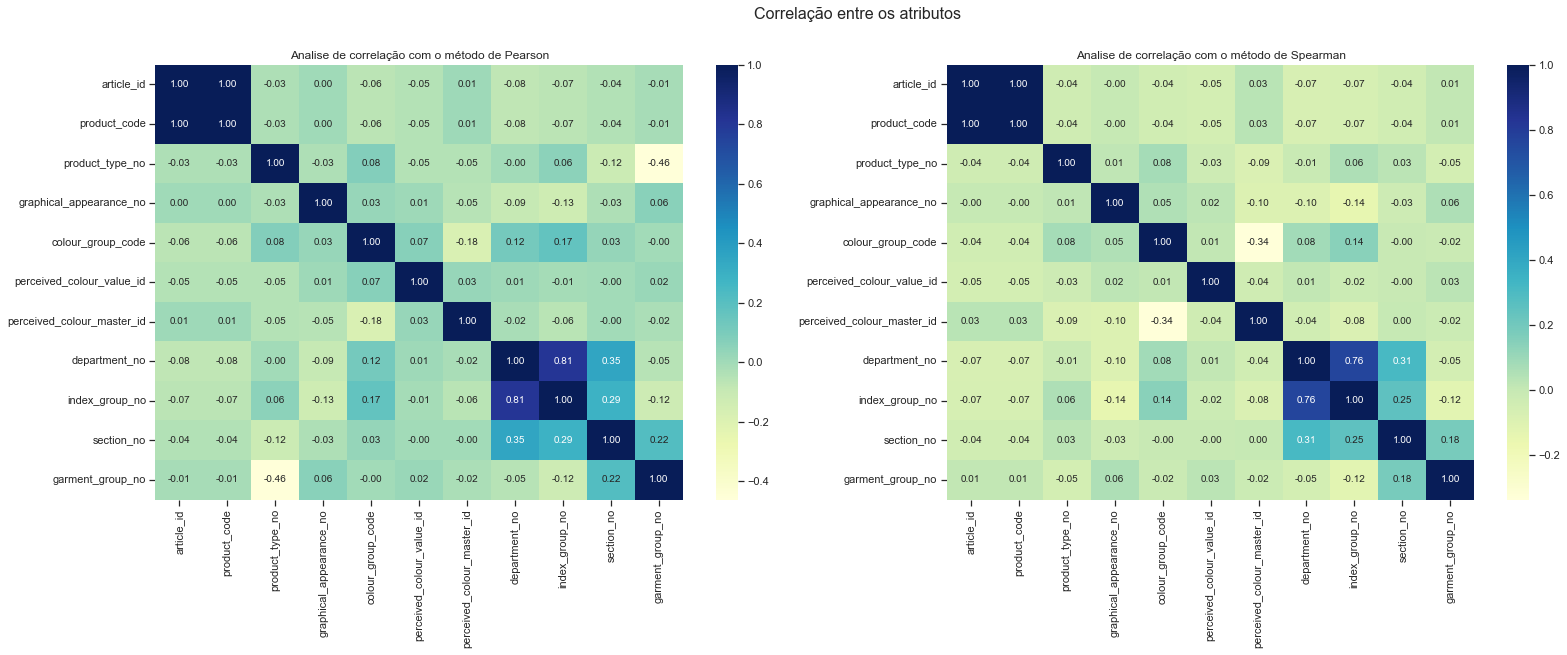

In [60]:
plt.figure(figsize=(26, 8))
plt.suptitle('Correlação entre os atributos', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('Analise de correlação com o método de Pearson')
sns.heatmap(articles.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f');

plt.subplot(1, 2, 2)
plt.title('Analise de correlação com o método de Spearman')
sns.heatmap(articles.corr(method="spearman"), annot = True, cmap= 'YlGnBu', fmt= '.2f');

#### Customers

In [61]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.000000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.000000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.000000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.000000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.000000,1.000000,ACTIVE,Regularly,52.000000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [62]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

customer_id: id do cliente `String` (categórico nominal)

FN: Se o se um cliente receber o boletim informativo de notícias de moda `int` (quantitativo discreto e binário assimétrico)

Active: indicação se o cliente é ativo `int` (quantitativo discreto e binário assimétrico)

club_member_status: status do cliente no clube de membros [ACTIVE, LEFT CLUB,PRE-CREATE] `String` (categórico nominal)

fashion_news_frequency: frequencia de acompanhamento de nótivias da moda [Monthly e Regularly] `String` (categórico ordinal)

age: idade do cliente `float64` (quantitativo contínuo)

postal_code: codigo postal do cliente criptografado `String` (categórico nominal)

In [63]:
customers = customers.rename(columns={"FN":"fashion_news_newsletter", "Active": "active_communication"})

In [64]:
customers.shape

(1371980, 7)

1371980 (quantidade de clientes em customers) - 1362281 (quantidade de clientes que fizeram uma compra em transactions) = 9699 

Logo tem que 9699 não possuem dados de compra

- Eliminando rows da tabela customers que possui clientes qua não possuem dados de compras em transactions

In [65]:
transactions_customers = transactions['customer_id'].unique()

In [66]:
len(transactions_customers)

1362281

In [67]:
customers = customers[customers['customer_id'].isin(transactions_customers)]
customers

,customer_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.000000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.000000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.000000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.000000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.000000,1.000000,ACTIVE,Regularly,52.000000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.000000,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.000000,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.000000,1.000000,ACTIVE,Regularly,21.000000,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.000000,1.000000,ACTIVE,Regularly,18.000000,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [68]:
customers.shape

(1362281, 7)

In [69]:
customers.isnull().sum()

customer_id                     0
fashion_news_newsletter    888922
active_communication       901382
club_member_status           6054
fashion_news_frequency      15999
age                         15761
postal_code                     0
dtype: int64

In [70]:
pd.get_dummies(customers["fashion_news_newsletter"]).head()

,1.000000
0,0
1,0
2,0
3,0
4,1


In [71]:
customers['fashion_news_newsletter'].fillna(0, inplace=True)

<AxesSubplot:>

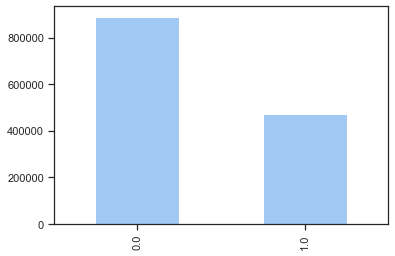

In [72]:
customers['fashion_news_newsletter'].value_counts().plot(kind='bar')

In [73]:
pd.get_dummies(customers["active_communication"]).head()

,1.000000
0,0
1,0
2,0
3,0
4,1


In [74]:
customers['active_communication'].fillna(0, inplace=True)

<AxesSubplot:>

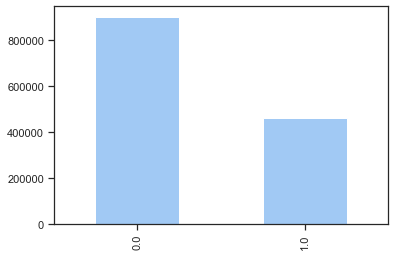

In [75]:
customers['active_communication'].value_counts().plot(kind='bar')

In [76]:
pd.get_dummies(customers["fashion_news_frequency"]).head()

,Monthly,NONE,None,Regularly
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,1


In [77]:
customers.loc[customers['fashion_news_frequency'] == 'None']

,customer_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code
898114,a79d9cbfaceb0d25a91caccfad167d4d6391fd5bb4292b...,1.000000,0.000000,ACTIVE,None,38.000000,58b7c5c27f8b5e8118a9786379601a344ab2e141550d93...


In [78]:
customers.loc[customers['fashion_news_frequency'] == 'None', ['fashion_news_frequency']] = "NONE"

In [79]:
customers["fashion_news_frequency"].fillna("NONE", inplace=True)

In [80]:
print(customers['fashion_news_frequency'].value_counts())

NONE         887598
Regularly    473843
Monthly         840
Name: fashion_news_frequency, dtype: int64


In [81]:
pd.get_dummies(customers["club_member_status"]).head()

,ACTIVE,LEFT CLUB,PRE-CREATE
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [82]:
customers['club_member_status'].fillna("NEVER JOINED", inplace=True)

ACTIVE          1263183
PRE-CREATE        92578
NEVER JOINED       6054
LEFT CLUB           466
Name: club_member_status, dtype: int64


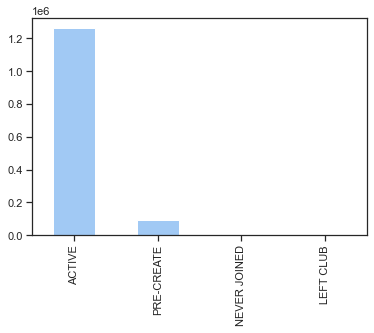

In [83]:
customers.club_member_status.value_counts().plot(kind='bar')
print(customers.club_member_status.value_counts())

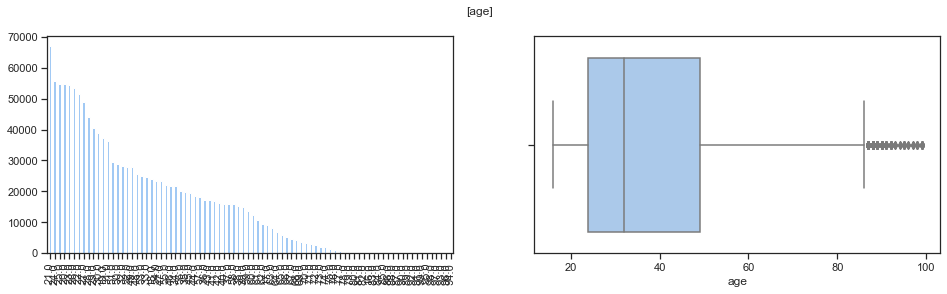

In [84]:
graph(customers, 'age')

In [85]:
max_x = customers['age'].max()
min_x = customers['age'].min()
print(f"Min: {min_x}  Max: {max_x}")

Min: 16.0  Max: 99.0


In [86]:
max_age, min_age = iqr_fence(customers['age'])
print(f"Min: {min_age}  Max: {max_age}")

Min: 16.0  Max: 86.0


In [87]:
interval_interquartil(customers, 'age')['age'].value_counts()

88.000000    48
87.000000    41
90.000000    24
89.000000    23
92.000000    17
91.000000    16
99.000000    13
95.000000    10
98.000000     7
97.000000     4
93.000000     4
96.000000     3
94.000000     3
Name: age, dtype: int64

In [88]:
customers.loc[customers['age'] > max_age, ['age']] = max_age

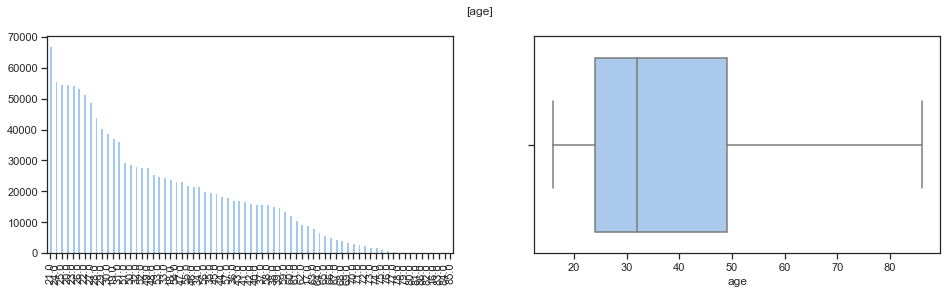

In [89]:
graph(customers, 'age')

In [90]:
customers["age"].fillna(0, inplace=True)

In [91]:
customers.isnull().sum()

customer_id                0
fashion_news_newsletter    0
active_communication       0
club_member_status         0
fashion_news_frequency     0
age                        0
postal_code                0
dtype: int64

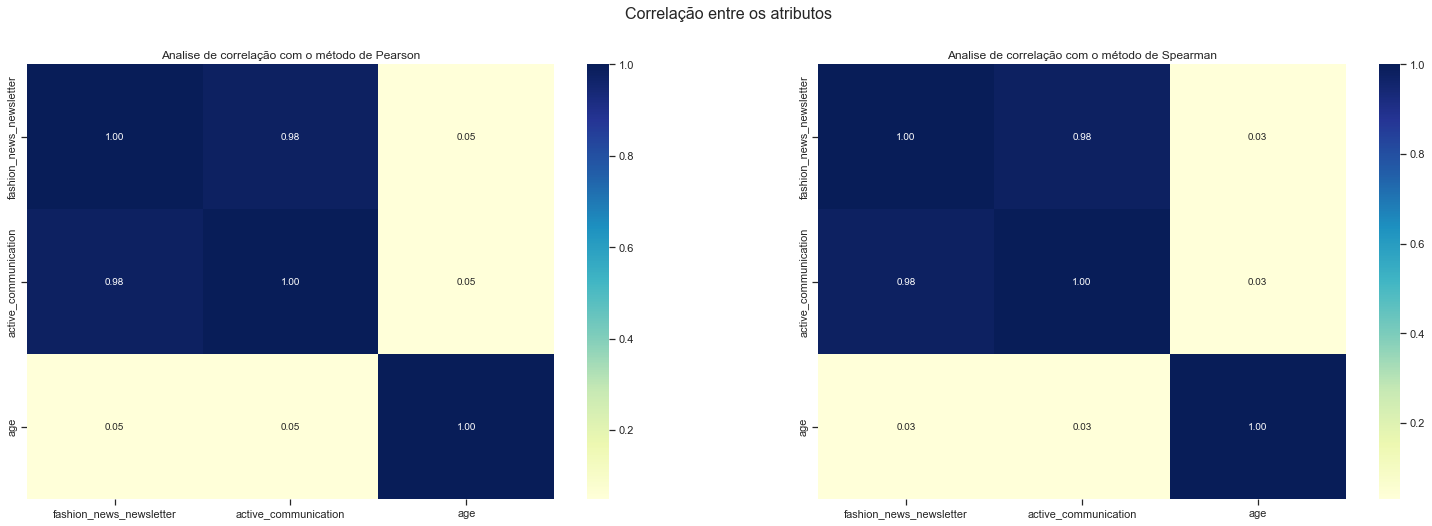

In [92]:
plt.figure(figsize=(26, 8))
plt.suptitle('Correlação entre os atributos', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('Analise de correlação com o método de Pearson')
sns.heatmap(customers.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f');

plt.subplot(1, 2, 2)
plt.title('Analise de correlação com o método de Spearman')
sns.heatmap(customers.corr(method="spearman"), annot = True, cmap= 'YlGnBu', fmt= '.2f');

In [93]:
customers

,customer_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.000000,0.000000,ACTIVE,NONE,49.000000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.000000,0.000000,ACTIVE,NONE,25.000000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.000000,0.000000,ACTIVE,NONE,24.000000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.000000,0.000000,ACTIVE,NONE,54.000000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.000000,1.000000,ACTIVE,Regularly,52.000000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.000000,0.000000,ACTIVE,NONE,24.000000,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.000000,0.000000,ACTIVE,NONE,21.000000,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.000000,1.000000,ACTIVE,Regularly,21.000000,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.000000,1.000000,ACTIVE,Regularly,18.000000,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


# Transformações

In [94]:
from sklearn.preprocessing import OneHotEncoder

In [95]:
customers

,customer_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.000000,0.000000,ACTIVE,NONE,49.000000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.000000,0.000000,ACTIVE,NONE,25.000000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.000000,0.000000,ACTIVE,NONE,24.000000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.000000,0.000000,ACTIVE,NONE,54.000000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.000000,1.000000,ACTIVE,Regularly,52.000000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.000000,0.000000,ACTIVE,NONE,24.000000,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.000000,0.000000,ACTIVE,NONE,21.000000,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.000000,1.000000,ACTIVE,Regularly,21.000000,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.000000,1.000000,ACTIVE,Regularly,18.000000,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [96]:
c_customers = customers.copy()

In [97]:
c_customers.shape

(1362281, 7)

In [98]:
def one_hot_encoder(dt, column_name):
    encoder = OneHotEncoder(handle_unknown = 'ignore')
    X = encoder.fit_transform(dt[[column_name]]).toarray()
    columns = encoder.get_feature_names_out([column_name])
    encoder_df = pd.DataFrame(X, columns=columns)
    return pd.concat([dt.reset_index(drop=True), encoder_df], axis='columns')

In [99]:
c_customers = one_hot_encoder(c_customers, 'club_member_status')
c_customers

,customer_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NEVER JOINED,club_member_status_PRE-CREATE
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.000000,0.000000,ACTIVE,NONE,49.000000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.000000,0.000000,0.000000,0.000000
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.000000,0.000000,ACTIVE,NONE,25.000000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,1.000000,0.000000,0.000000,0.000000
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.000000,0.000000,ACTIVE,NONE,24.000000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.000000,0.000000,0.000000,0.000000
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.000000,0.000000,ACTIVE,NONE,54.000000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,1.000000,0.000000,0.000000,0.000000
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.000000,1.000000,ACTIVE,Regularly,52.000000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1362276,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.000000,0.000000,ACTIVE,NONE,24.000000,7aa399f7e669990daba2d92c577b52237380662f36480b...,1.000000,0.000000,0.000000,0.000000
1362277,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.000000,0.000000,ACTIVE,NONE,21.000000,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...,1.000000,0.000000,0.000000,0.000000
1362278,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.000000,1.000000,ACTIVE,Regularly,21.000000,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...,1.000000,0.000000,0.000000,0.000000
1362279,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.000000,1.000000,ACTIVE,Regularly,18.000000,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...,1.000000,0.000000,0.000000,0.000000


In [100]:
c_customers = one_hot_encoder(c_customers, 'fashion_news_frequency')
c_customers

,customer_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NEVER JOINED,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_Regularly
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.000000,0.000000,ACTIVE,NONE,49.000000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.000000,0.000000,ACTIVE,NONE,25.000000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.000000,0.000000,ACTIVE,NONE,24.000000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.000000,0.000000,ACTIVE,NONE,54.000000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.000000,1.000000,ACTIVE,Regularly,52.000000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362276,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.000000,0.000000,ACTIVE,NONE,24.000000,7aa399f7e669990daba2d92c577b52237380662f36480b...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1362277,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.000000,0.000000,ACTIVE,NONE,21.000000,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1362278,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.000000,1.000000,ACTIVE,Regularly,21.000000,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1362279,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.000000,1.000000,ACTIVE,Regularly,18.000000,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [101]:
normalize(c_customers, 'age')

In [102]:
c_customers.head()

,customer_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NEVER JOINED,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_Regularly
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.000000,0.000000,ACTIVE,NONE,0.569767,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.000000,0.000000,ACTIVE,NONE,0.290698,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.000000,0.000000,ACTIVE,NONE,0.279070,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.000000,0.000000,ACTIVE,NONE,0.627907,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.000000,1.000000,ACTIVE,Regularly,0.604651,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [103]:
c_articles = articles.copy()

In [104]:
c_articles.head()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,detail_desc
0,108775015,108775,253,1010016,9,4,5,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
1,108775044,108775,253,1010016,10,3,9,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
2,108775051,108775,253,1010017,11,1,9,1676,A,1,16,1002,Jersey top with narrow shoulder straps.
3,110065001,110065,306,1010016,9,4,5,1339,B,1,61,1017,"Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,306,1010016,10,3,9,1339,B,1,61,1017,"Microfibre T-shirt bra with underwired, moulde..."


In [105]:
c_articles = one_hot_encoder(c_articles, 'index_code')
c_articles

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,...,index_code_A,index_code_B,index_code_C,index_code_D,index_code_F,index_code_G,index_code_H,index_code_I,index_code_J,index_code_S
0,108775015,108775,253,1010016,9,4,5,1676,A,1,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,108775044,108775,253,1010016,10,3,9,1676,A,1,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,108775051,108775,253,1010017,11,1,9,1676,A,1,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,110065001,110065,306,1010016,9,4,5,1339,B,1,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,110065002,110065,306,1010016,10,3,9,1339,B,1,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,302,1010014,9,4,5,7188,F,3,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
105538,953763001,953763,253,1010016,9,4,5,1919,A,1,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
105539,956217002,956217,265,1010016,9,4,5,1641,A,1,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
105540,957375001,957375,72,1010016,9,4,5,3946,D,2,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


![image](https://miro.medium.com/max/1400/1*0FDsAB9OelxojfmtkcLbgw.png)

In [106]:
count_transactions = transactions['customer_id'].value_counts().rename_axis('customer_id').reset_index(name='n_transactions')

In [107]:
c_transactions = transactions.copy()

In [108]:
transactions_join_customers = pd.merge(c_transactions, c_customers, on="customer_id", how="left")

In [109]:
transactions_join_customers.head()

,t_dat,customer_id,article_id,price,sales_channel_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,postal_code,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_NEVER JOINED,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_Regularly
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,0.000000,0.000000,ACTIVE,NONE,0.279070,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,0.000000,0.000000,ACTIVE,NONE,0.279070,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,1.000000,1.000000,ACTIVE,Regularly,0.372093,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,1.000000,1.000000,ACTIVE,Regularly,0.372093,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,1.000000,1.000000,ACTIVE,Regularly,0.372093,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [110]:
transactions_join_customers.shape

(31788324, 18)

In [111]:
dt = pd.merge(transactions_join_customers, c_articles, on="article_id", how="left")

In [112]:
dt.shape

(31788324, 40)

In [113]:
dt.isnull().sum()

t_dat                               0
customer_id                         0
article_id                          0
price                               0
sales_channel_id                    0
fashion_news_newsletter             0
active_communication                0
club_member_status                  0
fashion_news_frequency              0
age                                 0
postal_code                         0
club_member_status_ACTIVE           0
club_member_status_LEFT CLUB        0
club_member_status_NEVER JOINED     0
club_member_status_PRE-CREATE       0
fashion_news_frequency_Monthly      0
fashion_news_frequency_NONE         0
fashion_news_frequency_Regularly    0
product_code                        0
product_type_no                     0
graphical_appearance_no             0
colour_group_code                   0
perceived_colour_value_id           0
perceived_colour_master_id          0
department_no                       0
index_code                          0
index_group_

In [114]:
dt.head()

,t_dat,customer_id,article_id,price,sales_channel_id,fashion_news_newsletter,active_communication,club_member_status,fashion_news_frequency,age,...,index_code_A,index_code_B,index_code_C,index_code_D,index_code_F,index_code_G,index_code_H,index_code_I,index_code_J,index_code_S
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,0.000000,0.000000,ACTIVE,NONE,0.279070,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,0.000000,0.000000,ACTIVE,NONE,0.279070,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,1.000000,1.000000,ACTIVE,Regularly,0.372093,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,1.000000,1.000000,ACTIVE,Regularly,0.372093,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,1.000000,1.000000,ACTIVE,Regularly,0.372093,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Mineração

1. Produtos similares por compras de clientes
2. Produtos similares pelas caracteristicas

1. Filtragem Colaborativa
   Utilizar a informação das interações que ocorrem entre os usuários e os conteúdos para que, de forma coletiva, essa informação seja útil para inferir as preferências dos indivíduos.
2. Filtragem Baseada em Conteúdo

#### Utils

In [440]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


def img_reshape(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

In [442]:
path = 'C:/Users/enyal/Documents/tp_mineracao_dados/images/'
def display_articles(article_ids):
    rows = 4
    cols = 3

    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))

    for i in range(len(article_ids)):
        article_id = ("0" + str(article_ids[i]))[-10:]
        image_url = (f"{path}{article_id[:3]}/{article_id}.jpg")
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')

        try:
            Image.open(image_url)
            image = img_reshape(image_url)
            plt.imshow(image)
        except:
            None
        

In [461]:
path = 'C:/Users/enyal/Documents/tp_mineracao_dados/images/'
def show_image(article_id):
    article_id = ("0" + str(article_id))[-10:]
    img = img_reshape(f"{path}{article_id[:3]}/{article_id}.jpg")
    plt.imshow(img)
    plt.axis('off')

#### Clientes semelhantes por compra

In [559]:
mask = dt['t_dat'] > '2019-09-22'
transactions_ly = c_transactions.loc[mask]
#transactions_ly.drop(['sales_channel_id'],axis=1, inplace=True)

In [560]:
n_transactions = transactions_ly[:30000]

In [561]:
n_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
16889901,2019-09-23,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,743722002,0.016932,2
16889902,2019-09-23,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,768503001,0.020322,2
16889903,2019-09-23,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,753061003,0.010153,2
16889904,2019-09-23,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,748140001,0.015237,2
16889905,2019-09-23,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,748140001,0.015237,2


In [562]:
for i in n_transactions.columns[:1]:
    n_transactions[i] = pd.to_datetime(n_transactions[i]).dt.strftime("%Y%m%d")

C:\Users\enyal\AppData\Local\Temp\ipykernel_21660\1213483548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_transactions[i] = pd.to_datetime(n_transactions[i]).dt.strftime("%Y%m%d")


In [563]:
n_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
16889901,20190923,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,743722002,0.016932,2
16889902,20190923,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,768503001,0.020322,2
16889903,20190923,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,753061003,0.010153,2
16889904,20190923,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,748140001,0.015237,2
16889905,20190923,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2...,748140001,0.015237,2


In [587]:
ratings_matrix = n_transactions.pivot_table(
    index = 'customer_id', 
    columns ='article_id',
    values = 'sales_channel_id'
    ).fillna(0)
ratings_matrix.head()

# Transposta da matriz
X = ratings_matrix.T
X.head()

customer_id,0008804a45e7fbc8653ba8f5ce15880cb966ca220c52d2f8dcdeb954891277a7,000fb6e772c5d0023892065e659963da90b1866035558ec16fca51b0dcfb7e59,001529133de5f0cca01358473a1af5dd4ec3b8ba9c58e7b66957b81d6978def4,0015735a4905f31e769ca12963c6fbb44e026ceb88e0e3a9bbd17671b4c30f4c,0017da8f8aaff2be69599da3e09170b2261d66e646133b153b50cdaf9240e7b7,001a115cf237a707724f28640c8fab25c2c3b16b08a6ef77bc27a6a90d8c9ef2,001c1f8d70782f450524d3b3f404474dbd4a7d0d2ad78a0ec7db76248ce08346,00228762ecff5b8d1ea6a2e52b96dafa198febddbc3bf350eb611f28e61ea6ce,002470a7697bdc90b7bdb002b43cecf300fb76d22a7ba551ca6c9cb68cac1370,002c854e07a3962008b101821da001b3e7492b30e3b96656d613d6d3cb1493a7,...,ddff77a41ba20b8c7b07c6344eee4ab1a772daaefe64b75eeb86b703c8bb0213,de0fc49bef3d96fb9b389558ae4d6fc70b6465e114ab399663593e7deb70cc12,de170b2598061b6116594d7d90ee951519d5aa88cb3f19569cf5e72dbfebb483,de1742881a3f9052340a5bafd8c2895939c67bbb33758123d6ff57955f96e1d8,de1d64b9397fb7db46921dd3564754e4753ed5139ffb1a2dc348e4db09da4ed4,de1dec9332f085b02fdb49cd03f2227d8ed53c6e3684645c0988039d66e167b7,de2c763f879cd1fcb4d4c0af6a1103b1fdb62df9698c1aac72c1ad57e944c30e,de2f4006ee9e7616e09af502aa8c8dd39909108145c9fd82301f400978d043a1,de3156455d514ec5b911a6c5e1b7dfe9addf8533d974badb3f1f2ccc07faf4e8,de3dd76cc13f97efe5392e27c5c9c3a7016b3d5d1a539e41f48297d78a65c7de
article_id,,,,,,,,,,,,,,,,,,,,,
110065001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
110065002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
111565001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
111586001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
111593001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [566]:
X.shape

(7930, 8554)

Reduzindo a dimensionalidade usando Truncated SVD

In [567]:
from sklearn.decomposition import TruncatedSVD

In [568]:
SVD_model = TruncatedSVD(n_components=10)
decomposed_matrix = SVD_model.fit_transform(X)
decomposed_matrix.shape

(7930, 10)

In [569]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(7930, 7930)

In [570]:
correlation_matrix

array([[1.        , 0.27336669, 0.47129423, ..., 0.36599274, 0.69024988,
        0.57729228],
       [0.27336669, 1.        , 0.39042993, ..., 0.34983544, 0.53993227,
        0.50657309],
       [0.47129423, 0.39042993, 1.        , ..., 0.90653046, 0.65464201,
        0.71582301],
       ...,
       [0.36599274, 0.34983544, 0.90653046, ..., 1.        , 0.42419284,
        0.44290757],
       [0.69024988, 0.53993227, 0.65464201, ..., 0.42419284, 1.        ,
        0.95438935],
       [0.57729228, 0.50657309, 0.71582301, ..., 0.44290757, 0.95438935,
        1.        ]])

In [643]:
item = 705805001

product_names = list(X.index)
product_ID = product_names.index(item)
product_ID

2995

In [645]:
correlation_matrix[product_ID]

array([ 0.305542  , -0.08115993,  0.4320081 , ...,  0.25160992,
        0.53841133,  0.59173885])

In [646]:
correlation_product_ID = correlation_matrix[product_ID]

In [652]:
correlation = correlation_product_ID > 0.85
recommend = list(X.index[correlation])

#recommend.remove(item) 

recommend[0:10]

[309864013,
 309864014,
 375248023,
 507909003,
 563477010,
 568597007,
 568601007,
 578311009,
 586955001,
 594264006]

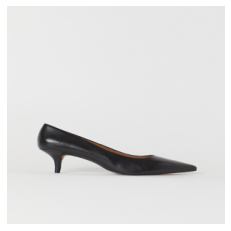

In [653]:
show_image(item)

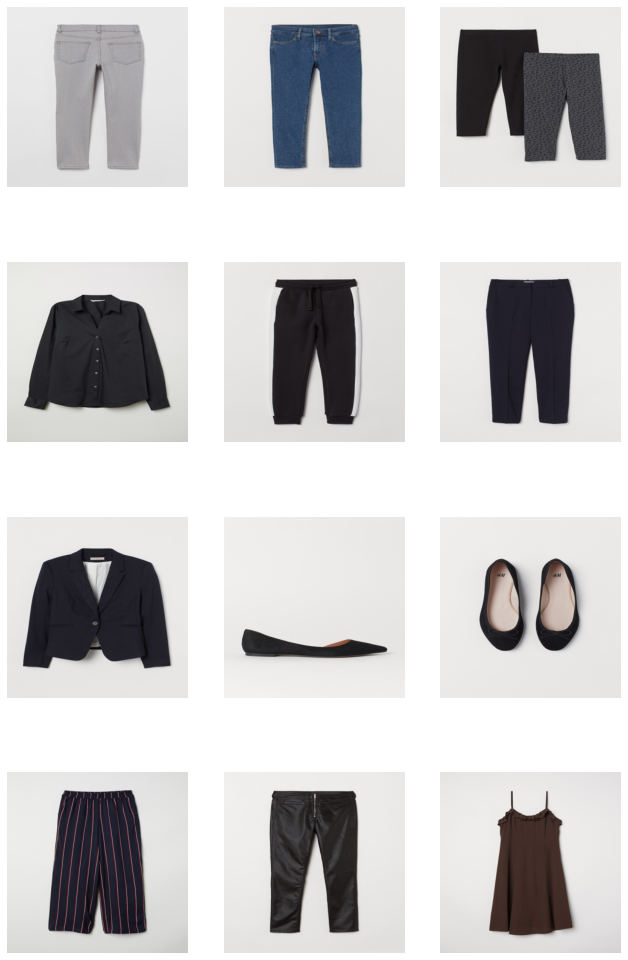

In [654]:
display_articles(recommend[0:12])

#### Produtos semelhantes através das suas descrições textuais

In [528]:
articles_nominal.head()

,article_id,prod_name,product_group_name,product_type_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,combined
0,108775015,strap top,garment upper body,vest top,solid,black,dark,black,jersey basic,ladieswear,ladieswear,womens everyday basics,jersey basic,jersey top with narrow shoulder straps.,strap top vest top garment upper body solid bl...
1,108775044,strap top,garment upper body,vest top,solid,white,light,white,jersey basic,ladieswear,ladieswear,womens everyday basics,jersey basic,jersey top with narrow shoulder straps.,strap top vest top garment upper body solid wh...
2,108775051,strap top (1),garment upper body,vest top,stripe,off white,dusty light,white,jersey basic,ladieswear,ladieswear,womens everyday basics,jersey basic,jersey top with narrow shoulder straps.,strap top (1) vest top garment upper body stri...
3,110065001,op t-shirt (idro),underwear,bra,solid,black,dark,black,clean lingerie,lingeries/tights,ladieswear,womens lingerie,"under-, nightwear","microfibre t-shirt bra with underwired, moulde...",op t-shirt (idro) bra underwear solid black da...
4,110065002,op t-shirt (idro),underwear,bra,solid,white,light,white,clean lingerie,lingeries/tights,ladieswear,womens lingerie,"under-, nightwear","microfibre t-shirt bra with underwired, moulde...",op t-shirt (idro) bra underwear solid white li...


In [249]:
cols = ['prod_name', 'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc']

In [208]:
articles_nominal.dtypes

article_id                       int64
prod_name                       object
product_group_name              object
product_type_name               object
graphical_appearance_name       object
colour_group_name               object
perceived_colour_value_name     object
perceived_colour_master_name    object
department_name                 object
index_name                      object
index_group_name                object
section_name                    object
garment_group_name              object
index_group_name                object
detail_desc                     object
dtype: object

In [215]:
articles_nominal.isnull().sum()

article_id                      0
prod_name                       0
product_group_name              0
product_type_name               0
graphical_appearance_name       0
colour_group_name               0
perceived_colour_value_name     0
perceived_colour_master_name    0
department_name                 0
index_name                      0
index_group_name                0
section_name                    0
garment_group_name              0
index_group_name                0
detail_desc                     0
dtype: int64

In [246]:
#Tratandom string
for i in articles_nominal.columns[1:]:
    articles_nominal[i] = articles_nominal[i].str.lower().replace(" ","").replace("."," ").replace(","," ")

In [250]:
articles_nominal['combined'] = articles_nominal[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [251]:
print(articles_nominal[:1]['combined'].values)

['strap top vest top garment upper body solid black dark black jersey basic ladieswear ladieswear womens everyday basics jersey basic jersey top with narrow shoulder straps.']


In [349]:
articles_nominal.shape

(105542, 15)

In [364]:
articles_f = articles_nominal.loc[:10000].copy()

In [662]:
articles_f[2342:2988]

,article_id,prod_name,product_group_name,product_type_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,combined
2342,403479008,billy s/s bb 2pack,garment upper body,t-shirt,solid,black,dark,black,young boy jersey basic,children sizes 134-170,baby/children,boys underwear & basics,jersey basic,t-shirts in organic cotton jersey with a round...,billy s/s bb 2pack t-shirt garment upper body ...
2343,403490011,elias basic v-neck bb 2-p,garment upper body,t-shirt,solid,black,dark,black,young boy jersey basic,children sizes 134-170,baby/children,boys underwear & basics,jersey basic,v-neck t-shirts in organic cotton jersey.,elias basic v-neck bb 2-p t-shirt garment uppe...
2344,403490012,elias basic v-neck bb 2-p,garment upper body,t-shirt,solid,dark blue,dark,blue,young boy jersey basic,children sizes 134-170,baby/children,boys underwear & basics,jersey basic,v-neck t-shirts in organic cotton jersey.,elias basic v-neck bb 2-p t-shirt garment uppe...
2345,403490017,elias basic 2-p v-neck bb,garment upper body,t-shirt,solid,dark blue,bright,blue,young boy jersey basic,children sizes 134-170,baby/children,boys underwear & basics,jersey basic,v-neck t-shirts in organic cotton jersey.,elias basic 2-p v-neck bb t-shirt garment uppe...
2346,403579007,jones l/s henley bb,garment upper body,t-shirt,stripe,dark blue,dark,blue,young boy jersey basic,children sizes 134-170,baby/children,boys underwear & basics,jersey basic,long-sleeved jersey t-shirt in a cotton blend ...,jones l/s henley bb t-shirt garment upper body...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,443696061,tp bo basic oh bb,garment upper body,hoodie,solid,yellow,medium,yellow,young boy jersey basic,children sizes 134-170,baby/children,boys underwear & basics,jersey basic,long-sleeved top in sweatshirt fabric made fro...,tp bo basic oh bb hoodie garment upper body so...
2984,443860005,polo s/s highline,garment upper body,polo shirt,solid,dark red,dark,red,knitwear,menswear,menswear,men suits & tailoring,knitwear,fine-knit polo shirt in a silk and cotton blen...,polo s/s highline polo shirt garment upper bod...
2985,443860011,s/s polo highline,garment upper body,polo shirt,solid,light grey,dusty light,grey,knitwear,menswear,menswear,men suits & tailoring,knitwear,fine-knit polo shirt in a silk and cotton blen...,s/s polo highline polo shirt garment upper bod...
2986,443860012,s/s polo highline,garment upper body,polo shirt,solid,blue,medium,blue,knitwear,menswear,menswear,men suits & tailoring,knitwear,fine-knit polo shirt in a silk and cotton blen...,s/s polo highline polo shirt garment upper bod...


Term Frequency Inverse Document Frequency - TF-IDF

<img alt="TF-IDF" src="https://miro.medium.com/max/1100/1*WnIj9dn7cEYlx_d5xhdROQ@2x.jpeg"/>

In [365]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
articles_f['combined'] = articles_f['combined'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(articles_f['combined'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(10001, 3877)

In [366]:
indices = pd.Series(articles_f.index, index=articles_f['article_id']).drop_duplicates()

In [367]:
# Function that takes in article_id as input and outputs most similar articles
def get_recommendations(title, cosine_sim):
    # Get the index of the article that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all articles
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar articles
    sim_scores = sim_scores[:12]

    # Get the article indices
    article_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar articles
    return articles_nominal['article_id'].iloc[article_indices]

<img alt="cosine similarity" src="https://miro.medium.com/max/640/1*ElwLV9oIJNyHkvw39nxV0w.png"/>

In [686]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [687]:
item = 403479008

In [689]:
recom = list(get_recommendations(item, cosine_sim))
recom

[403479008,
 403479005,
 403479007,
 403479001,
 403490011,
 403490012,
 355325001,
 403490017,
 512743001,
 512743004,
 260736029,
 260736025]

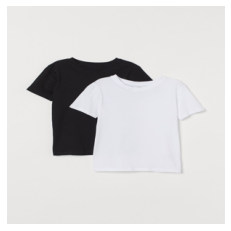

In [690]:
show_image(item)

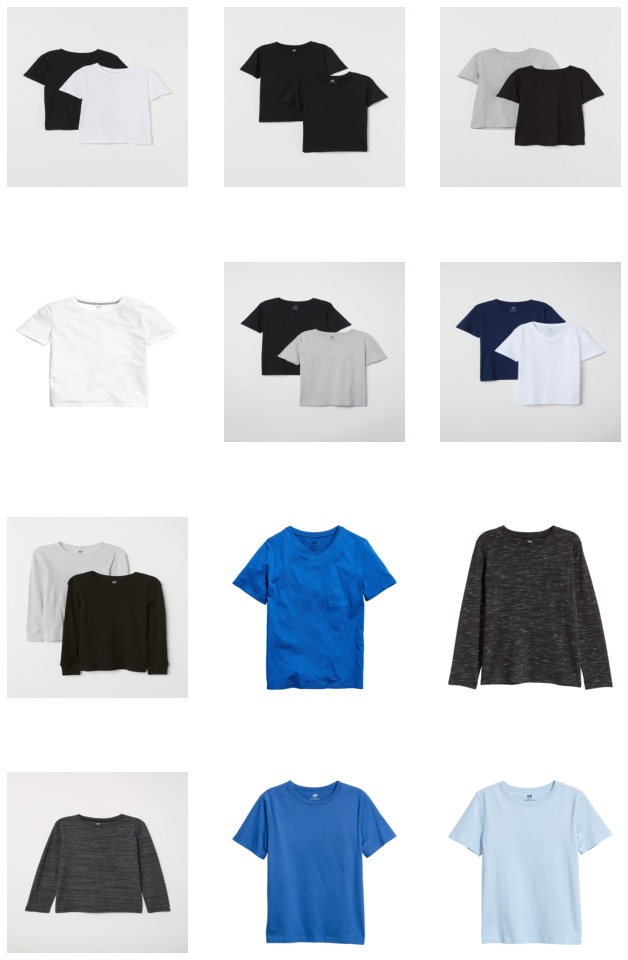

In [691]:
display_articles(recom)